<a href="https://www.kaggle.com/code/scr0ll0/eda-with-nlp?scriptVersionId=145387646" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from wordcloud import WordCloud

import tensorflow as tf
import tensorflow_decision_forests as tfdf

from nltk.corpus import stopwords
from nltk.util import ngrams

# Loading Data

In [2]:
prompts_train = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')
prompts_test = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv')
summaries_train = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')
summaries_test = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv')

In [3]:
prompts_train.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [4]:
prompts_test.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,abc123,Summarize...,Example Title 1,Heading\nText...
1,def789,Summarize...,Example Title 2,Heading\nText...


In [5]:
summaries_train.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [6]:
summaries_test.head()

,student_id,prompt_id,text
0,000000ffffff,abc123,Example text 1
1,111111eeeeee,def789,Example text 2
2,222222cccccc,abc123,Example text 3
3,333333dddddd,def789,Example text 4


# Merging Data
We want to merge on prompt_id.

In [7]:
summaries_train = summaries_train.merge(prompts_train, on='prompt_id')
summaries_test = summaries_test.merge(prompts_test, on='prompt_id')

In [8]:
summaries_train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


# EDA

In [9]:
summaries_train.describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


In [10]:
summaries_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   student_id       7165 non-null   object 
 1   prompt_id        7165 non-null   object 
 2   text             7165 non-null   object 
 3   content          7165 non-null   float64
 4   wording          7165 non-null   float64
 5   prompt_question  7165 non-null   object 
 6   prompt_title     7165 non-null   object 
 7   prompt_text      7165 non-null   object 
dtypes: float64(2), object(6)
memory usage: 447.9+ KB


In [11]:
len(summaries_train['student_id'].unique())

7165

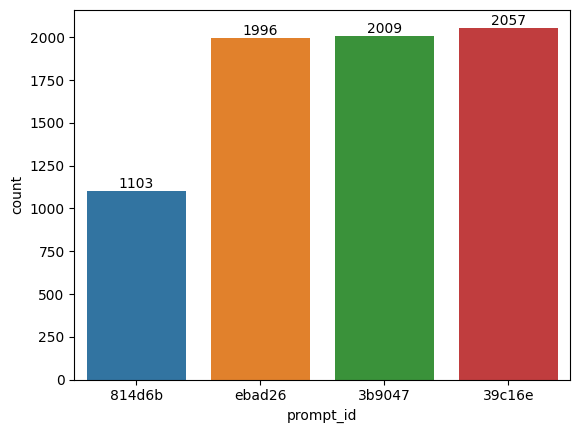

In [12]:
ax = sns.countplot(x=summaries_train['prompt_id'])
for container in ax.containers:
    ax.bar_label(container)

[Text(0.5, 1.0, 'Character Count')]

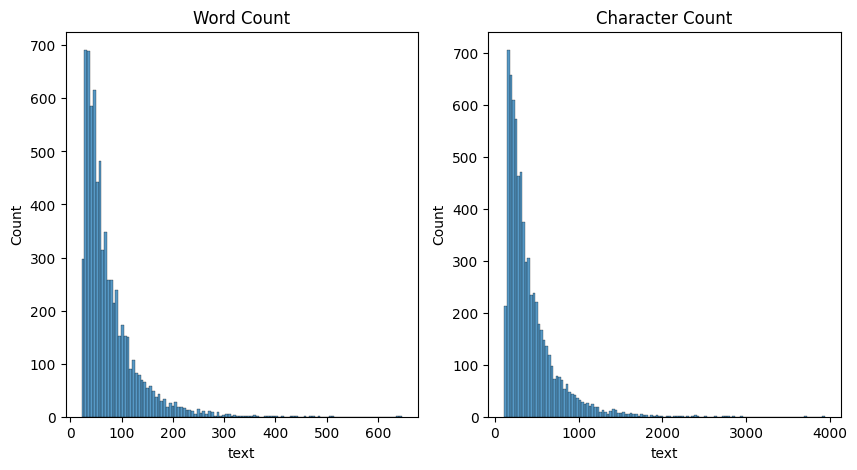

In [13]:
#Whole Dataset
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.histplot(x=summaries_train['text'].apply(lambda x: len(x.split()))).set(title='Word Count')
plt.subplot(1, 2, 2)
sns.histplot(x=summaries_train['text'].apply(lambda x: len(x))).set(title='Character Count')

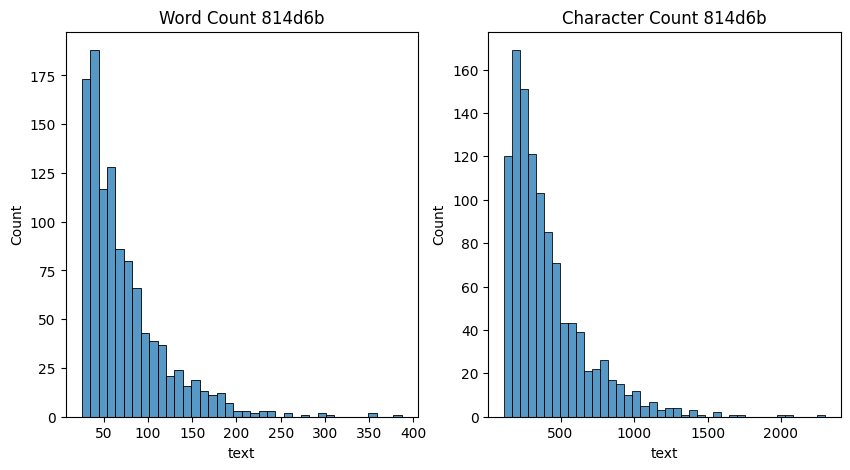

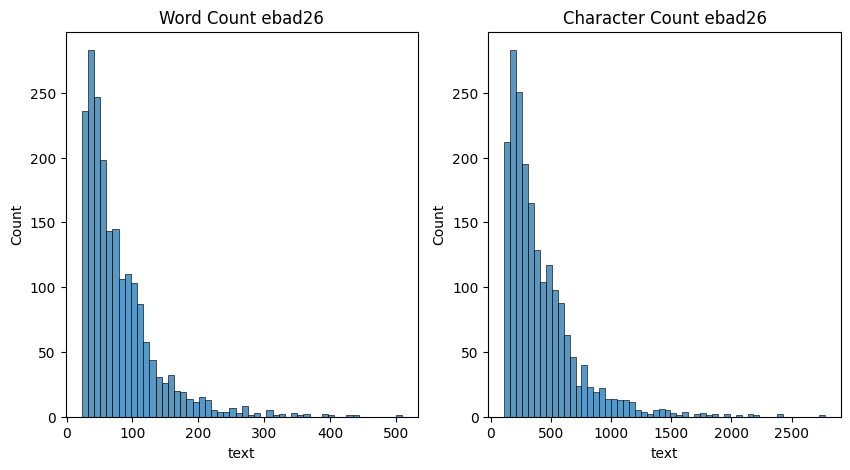

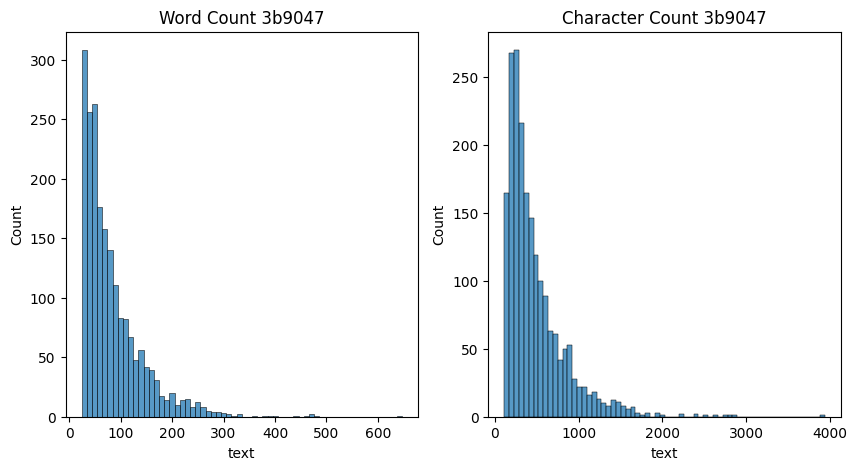

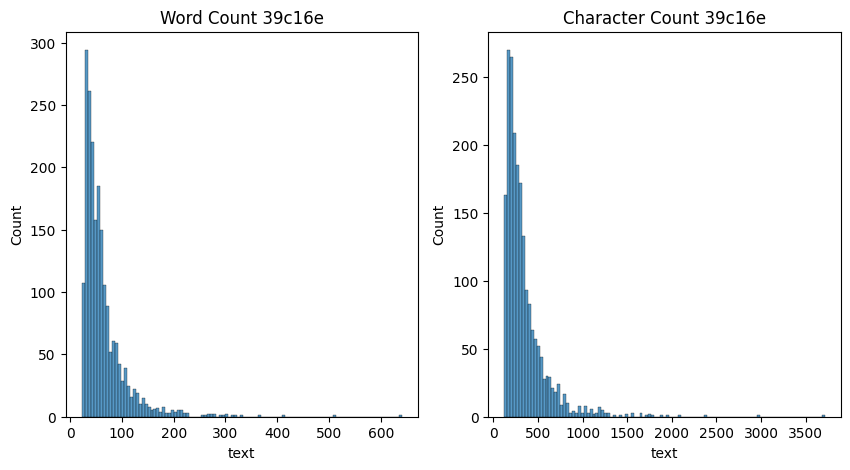

In [14]:
#By Prompt ID
for i in summaries_train['prompt_id'].unique():
    plt.figure(figsize = (10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(x=summaries_train[summaries_train['prompt_id'] == i]['text'].apply(lambda x: len(x.split()))).set(title='Word Count ' + i)
    plt.subplot(1, 2, 2)
    sns.histplot(x=summaries_train[summaries_train['prompt_id'] == i]['text'].apply(lambda x: len(x))).set(title='Character Count ' + i)

In [15]:
#Most Frequent Words
summaries_train['text'].str.split(expand=True).stack().value_counts()

the          36856
and          19553
to           15600
of           14588
a            10873
             ...  
somehting        1
world's          1
presuring        1
Enough           1
circle           1
Name: count, Length: 22410, dtype: int64

In [16]:
#By Prompt
for i in summaries_train['prompt_id'].unique():
    print('Prompt ' + i)
    print(summaries_train[summaries_train['prompt_id'] == i]['text'].str.split(expand=True).stack().value_counts())
    print('\n')

Prompt 814d6b
the          4953
to           3140
of           2737
and          2418
was          2040
             ... 
peolpe          1
useful          1
childrens       1
devolpoed       1
long,           1
Name: count, Length: 5116, dtype: int64


Prompt ebad26
the                  9913
and                  6147
would                5306
to                   5175
it                   5161
                     ... 
usefull                 1
sausage.According       1
glycerin,and            1
hoopers,and             1
manipulation            1
Name: count, Length: 6940, dtype: int64


Prompt 3b9047
the           15219
and            7304
were           5296
of             4424
to             3636
              ...  
scribes)          1
goventment        1
involement        1
war",             1
ainceint          1
Name: count, Length: 9617, dtype: int64


Prompt 39c16e
the             6771
a               4937
of              4157
and             3684
to              3649
         

<Axes: >

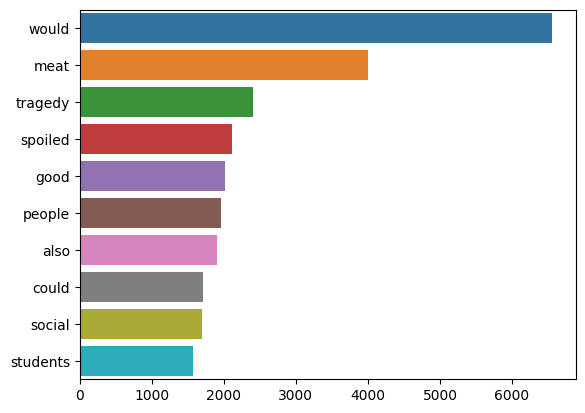

In [17]:
#Most Common Words
frequent = summaries_train['text'].str.split(expand=True).stack().value_counts()
x, y = [], []
for word, count in enumerate(frequent):
    if len(x) == 10:
        break
    if (frequent.index[word].lower() not in set(stopwords.words('english'))):
        x.append(frequent.index[word])
        y.append(count)
sns.barplot(x=y, y=x)

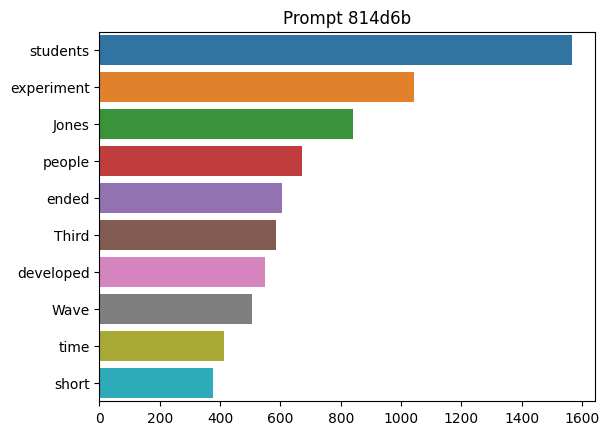

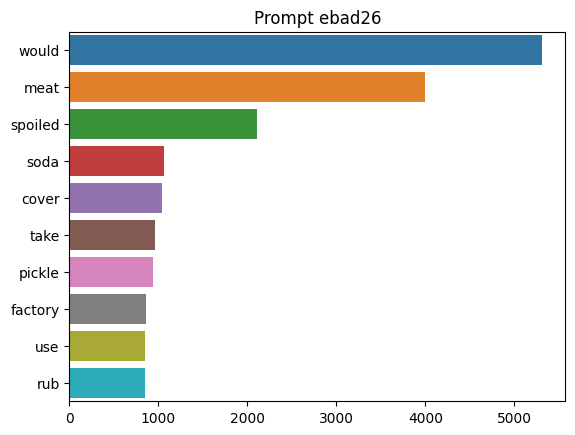

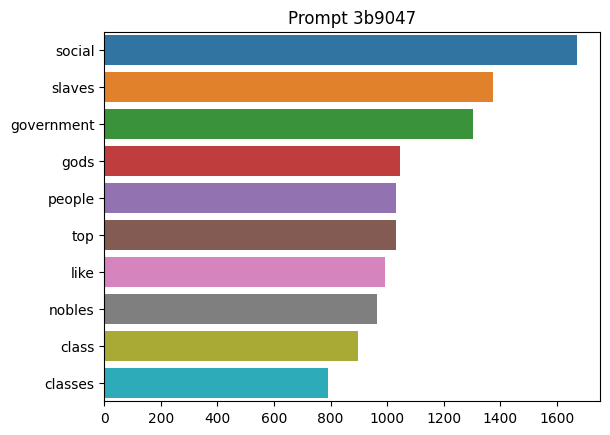

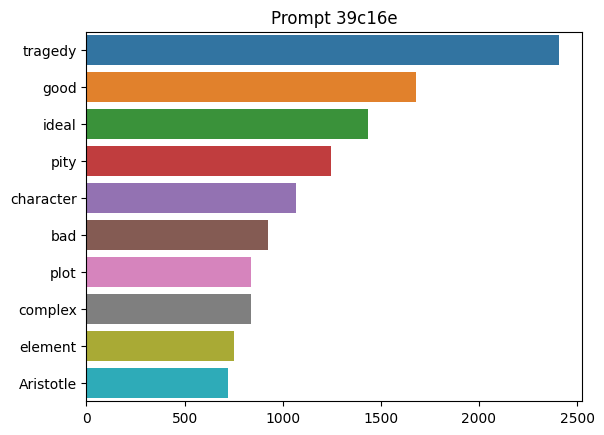

In [18]:
#Repeat for Prompts
for i in summaries_train['prompt_id'].unique():
    frequent = summaries_train[summaries_train['prompt_id'] == i]['text'].str.split(expand=True).stack().value_counts()
    x, y = [], []
    for word, count in enumerate(frequent): 
        if len(x) == 10: #Top 10 Words
            break
        if (frequent.index[word].lower() not in set(stopwords.words('english'))):
            x.append(frequent.index[word])
            y.append(count)
    sns.barplot(x=y, y=x).set(title = ('Prompt ' + i))
    plt.show()

<Axes: >

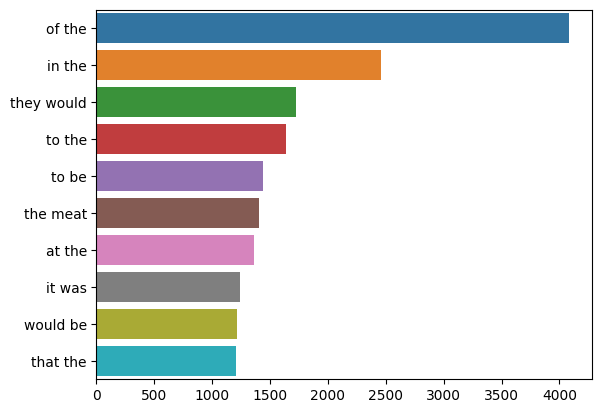

In [19]:
#Pairs of Words
frequent = summaries_train['text'].apply(lambda x: list(ngrams(x.split(), 2))).explode().value_counts()
x, y = [], []
for word, count in enumerate(frequent):
    if len(x) == 10:
        break
    x.append(' '.join(frequent.index[word]))
    y.append(count)
sns.barplot(x=y, y=x)

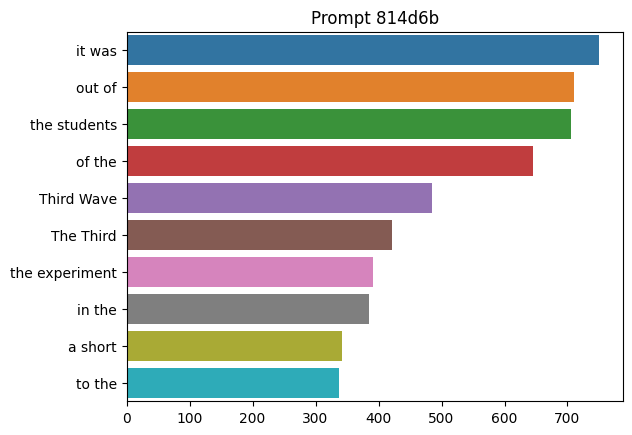

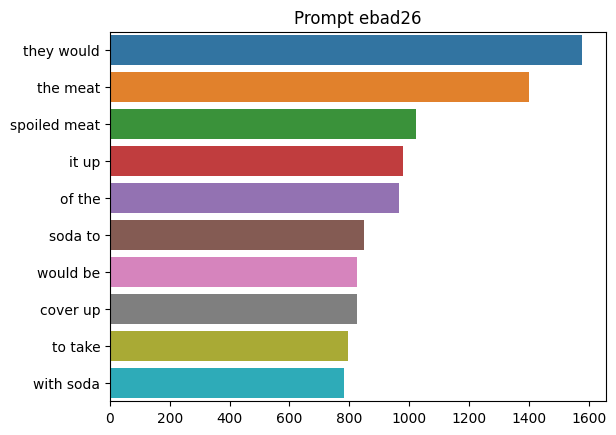

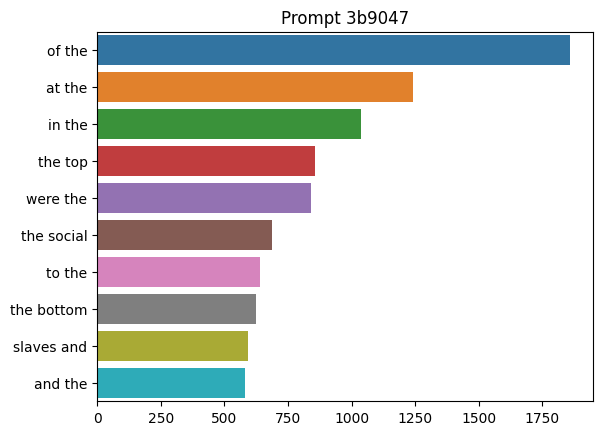

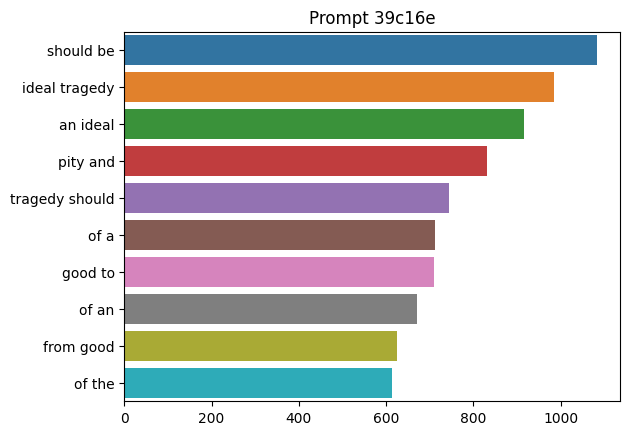

In [20]:
#By Prompt
for i in summaries_train['prompt_id'].unique():
    frequent = summaries_train[summaries_train['prompt_id'] == i]['text'].apply(lambda x: list(ngrams(x.split(), 2))).explode().value_counts()
    x, y = [], []
    for word, count in enumerate(frequent): 
        if len(x) == 10: #Top 10 Words
            break
        x.append(' '.join(frequent.index[word]))
        y.append(count)
    sns.barplot(x=y, y=x).set(title = ('Prompt ' + i))
    plt.show()

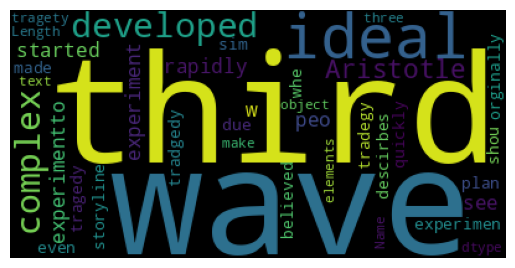

In [21]:
#Wordcloud
wordcloud = WordCloud(stopwords=stopwords.words('english')).generate(str(summaries_train['text']))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

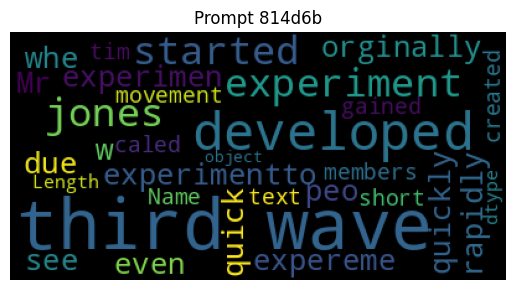

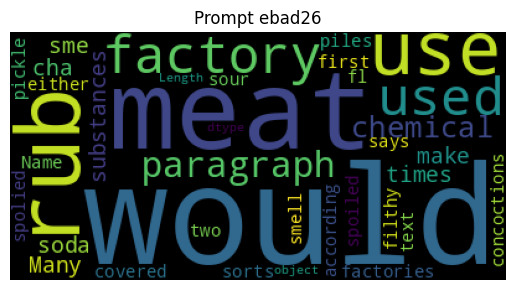

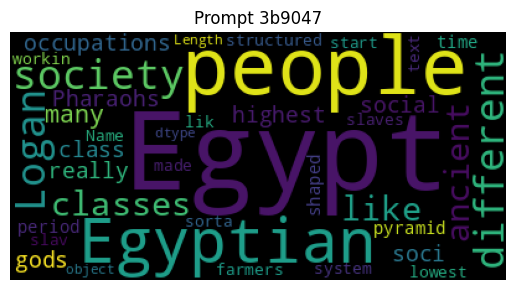

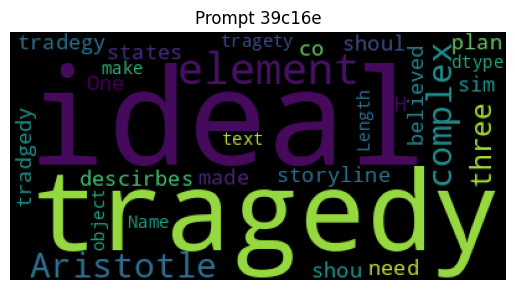

In [22]:
for i in summaries_train['prompt_id'].unique():
    wordcloud = WordCloud(stopwords=stopwords.words('english')).generate(str(summaries_train[summaries_train['prompt_id'] == i]['text']))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title("Prompt " + i)
    plt.show()

<Axes: xlabel='content', ylabel='Count'>

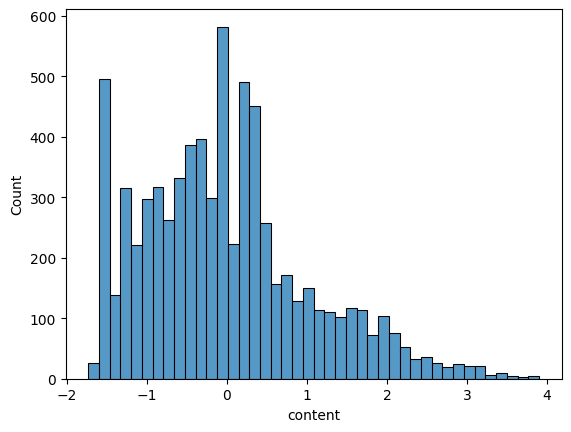

In [23]:
#Content
sns.histplot(summaries_train['content'])

<Axes: xlabel='prompt_id', ylabel='content'>

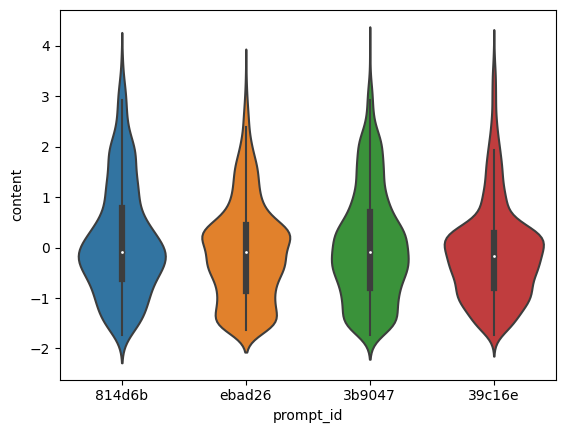

In [24]:
#By prompt
sns.violinplot(summaries_train, x='prompt_id', y='content')

<Axes: xlabel='wording', ylabel='Count'>

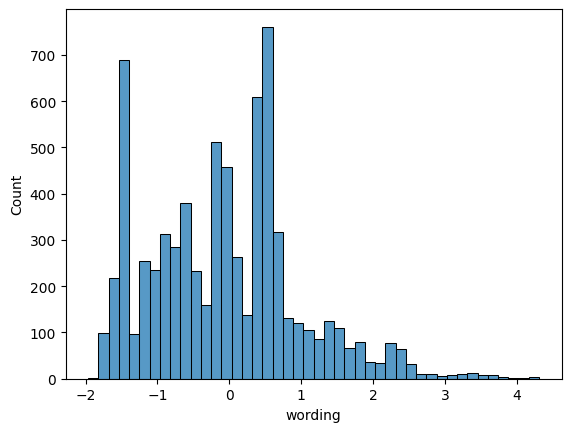

In [25]:
#Wording
sns.histplot(summaries_train['wording'])

<Axes: xlabel='prompt_id', ylabel='wording'>

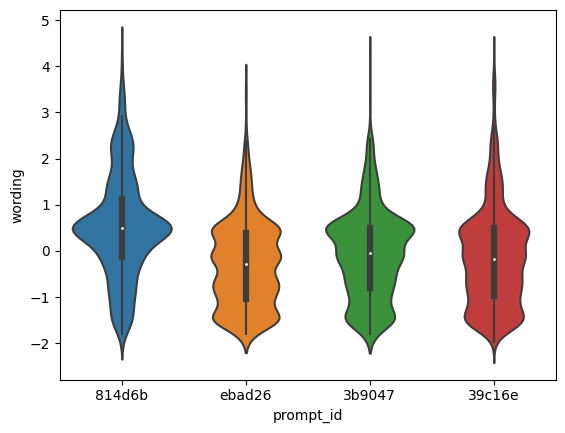

In [26]:
sns.violinplot(summaries_train, x='prompt_id', y='wording')